In [1]:
#coding=utf-8
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.patches as mpatches

from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import numpy as np
import pandas as pd

Fix the random seed for replayability

In [2]:
random_state = np.random.RandomState(4321)

# Read raw data

In [3]:
## Load the train data
train = np.load("train.npz")
X_train, y_train = train["X"], train["y"]

# Plot data representatives

In [4]:
# Arrange images as a 10x10 matrix with each class in the corresponding row.
image_shape = (28, 28)

N = y_train.shape[0]
image_classes = []

for target_class in range(10):
    class_inds = np.where(y_train == target_class)[0]
    # select 10 random sub inds 
    class_sub_inds = random_state.choice(class_inds, 10)
    image_classes.append(X_train[class_sub_inds, :])

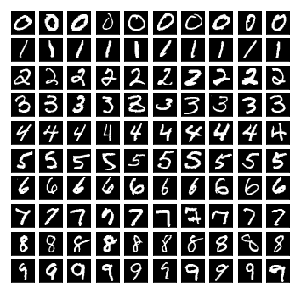

In [5]:
#plot selected representatives
n_row, n_col = 10, 10

plt.figure(figsize=(n_col/2, n_row/2))
for i in range (0, n_row):
    for j in range(0, n_col):
        plt.subplot(n_row, n_col, i * n_row + j + 1)
        plt.imshow(image_classes[i][j].reshape(image_shape), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
# plt.tight_layout()

## Effects of simple convolutions

Convolutional step

In [6]:
from scipy.signal import convolve2d

def conv2d(image, conv, normalize=False):
    conv_ = (conv / conv.sum(dtype=np.float)) if normalize else conv
    return convolve2d(image, conv_, mode='valid',
                      boundary='fill', fillvalue=0)

Max pooling: tak the max pixel value within an SxS **nonoverlapping sliding window**

In [7]:
from scipy.ndimage.filters import maximum_filter

def max_pool(image, size=3, step=None):
    result_ = maximum_filter(image, size=(size, size),
                             mode='constant', cval=0,
                             origin=0)

    # Compute the bounds of the new image which use the FULL S x S window
    #  `maximum_filter` centers the window approximately just at its centre.
    slice_ = slice(size // 2,
                   size // 2 - size + 1 if size > 2 else None,
                   size if not isinstance(step, int) else step)
    return result_[slice_, slice_]

2D Convoluton + Max-pooling

In [8]:
def c2dm(image, filters, size=3, normalize=False):
    """Image is HxW array, filters is FxSxS set of F different
    filters of size SxS.
    
    Filters are reversed in order to match the natural image directions.
    """
    return np.stack([max_pool(conv2d(image,
                                     filter_[::-1, ::-1],
                                     normalize=normalize),
                              size=size)
                     for filter_ in filters], axis=0)

Spawn some filters

In [9]:
filters_list = []

diagonal filters

In [10]:
filters_list.append(np.array(
    [[1, 0, 0, 0, 0],
     [1, 1, 1, 0, 0],
     [0, 1, 1, 1, 0],
     [0, 0, 1, 1, 1],
     [0, 0, 0, 0, 1]], np.float))

filters_list.append(np.array(
    [[0, 0, 0, 0, 1],
     [0, 0, 1, 1, 1],
     [0, 1, 1, 1, 0],
     [1, 1, 1, 0, 0],
     [1, 0, 0, 0, 0]], np.float))

axis aligned filters

In [11]:
filters_list.append(np.array(
    [[0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 1, 0, 0]], np.float))

filters_list.append(np.array(
    [[0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0],
     [1, 1, 1, 1, 1],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0]], np.float))

Some angles

In [12]:
filters_list.append(np.array(
    [[0, 0, 0, 1, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 1, 1, 0],
     [1, 1, 1, 1, 0],
     [0, 0, 0, 0, 0]], np.float))

filters_list.append(np.array(
    [[0, 1, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 1, 1, 0, 0],
     [0, 1, 1, 1, 1],
     [0, 0, 0, 0, 0]], np.float))

filters_list.append(np.array(
    [[0, 0, 0, 0, 0],
     [0, 1, 1, 1, 1],
     [0, 1, 1, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 1, 0, 0, 0]], np.float))

filters_list.append(np.array(
    [[0, 0, 0, 0, 0],
     [1, 1, 1, 1, 0],
     [0, 0, 1, 1, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 1, 0]], np.float))

Some weird shape

In [13]:
filters_list.append(np.array(
    [[0, 0, 1, 0, 0],
     [0, 1, 1, 1, 0],
     [1, 1, 0, 1, 1],
     [0, 1, 1, 1, 0],
     [0, 0, 1, 0, 0]], np.float))

Combine them into one filter "cube"


In [14]:
filters = np.stack(filters_list, axis=0)

A helper function

In [15]:
def illustration_helper(image, filter):
    filter_ = filter / filter.sum(keepdims=True, dtype=np.float)
    return convolve2d(image, filter_[::-1, ::-1],
                      mode='full', boundary='fill', fillvalue=0)

<hr/>

Plot filter responses

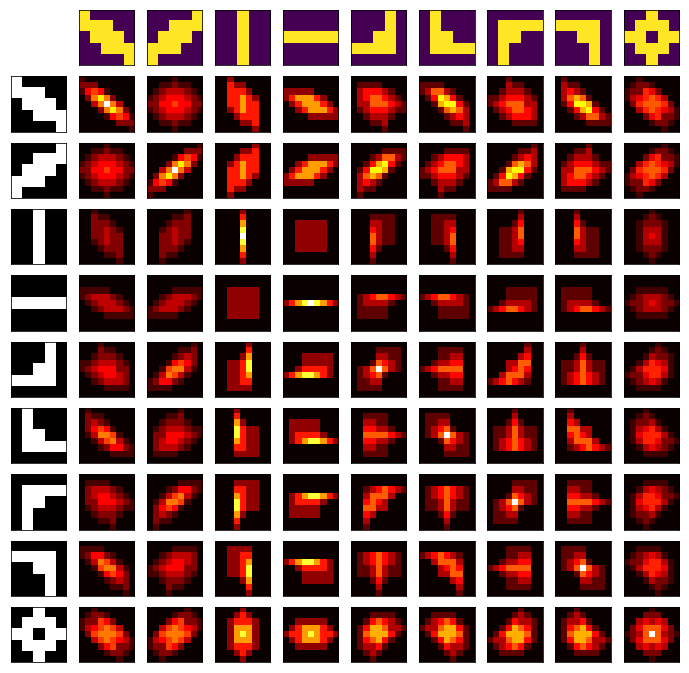

In [16]:
n_row, n_col = filters.shape[0] + 1, filters.shape[0] + 1

plt.figure(figsize=(12, 12))
for j in range(filters.shape[0]):
    plt.subplot(n_row, n_col, 1 + (j + 1))
    plt.imshow(filters[j], interpolation='nearest', vmin=0, vmax=1)
    plt.xticks(())
    plt.yticks(())

for i in range(filters.shape[0]):
    exemplar = filters[i]
    convolved = np.stack([illustration_helper(exemplar, filter_)
                          for filter_ in filters], axis=0)

    plt.subplot(n_row, n_col, 1 + (i + 1) * n_col)
    plt.imshow(exemplar, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=1)
    plt.xticks(())
    plt.yticks(())

    for j in range(convolved.shape[0]):
        plt.subplot(n_row, n_col, 1 + (i + 1) * n_col + (j + 1))
#         plt.imshow(exemplar, cmap=plt.cm.gray, interpolation='nearest')
        plt.imshow(convolved[j], cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=1)
        plt.xticks(())
        plt.yticks(())
# plt.tight_layout()

The hotter the color (whiter) the stronger the response of the filter.
Redder colors indicate thath the response is weak.

<hr/>

Apply conv2d filters to the digits

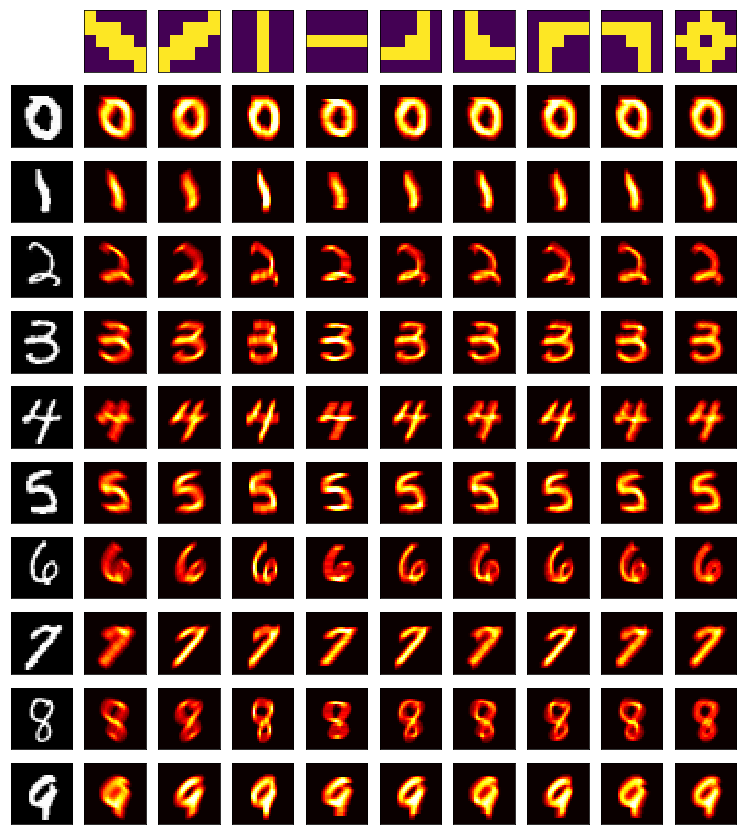

In [17]:
n_row, n_col = 10 + 1, filters.shape[0] + 1

plt.figure(figsize=(13, 15))
for j in range(filters.shape[0]):
    plt.subplot(n_row, n_col, 1 + 0 + (j + 1))
    plt.imshow(filters[j], interpolation='nearest', vmin=0, vmax=1)
    plt.xticks(()) ; plt.yticks(())

for i in range(10):
    exemplar = image_classes[i][1].reshape(image_shape)
    convolved = np.stack([illustration_helper(exemplar, filter_)
                          for filter_ in filters], axis=0)

    plt.subplot(n_row, n_col, 1 + (i + 1) * n_col)
    plt.imshow(exemplar, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    plt.xticks(()) ; plt.yticks(())

    for j in range(filters.shape[0]):
        plt.subplot(n_row, n_col, 1 + (i + 1) * n_col + (j + 1))
        plt.imshow(convolved[j], cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=255)
        plt.xticks(()) ; plt.yticks(())
# # plt.tight_layout()


Apply conv2d+max filters to the digits

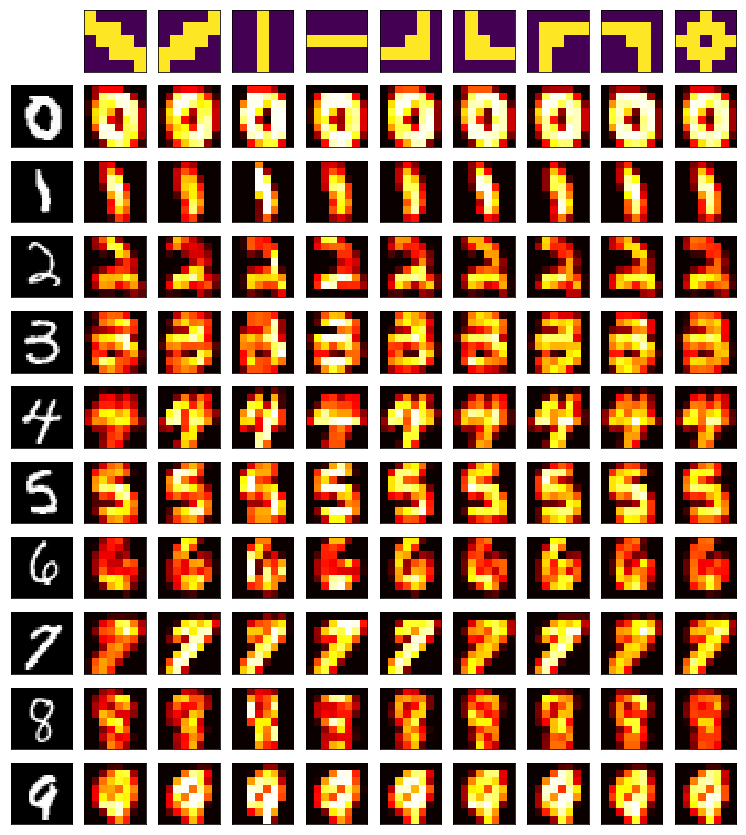

In [18]:
n_row, n_col = 10 + 1, filters.shape[0] + 1

plt.figure(figsize=(13, 15))
for j in range(filters.shape[0]):
    plt.subplot(n_row, n_col, 1 + 0 + (j + 1))
    plt.imshow(filters[j], interpolation='nearest', vmin=0, vmax=1)
    plt.xticks(()) ; plt.yticks(())

for i in range(10):
    exemplar = image_classes[i][1].reshape(image_shape)
    convolved = c2dm(exemplar, filters, normalize=True)

    plt.subplot(n_row, n_col, 1 + (i + 1) * n_col)
    plt.imshow(exemplar, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    plt.xticks(()) ; plt.yticks(())

    for j in range(filters.shape[0]):
        plt.subplot(n_row, n_col, 1 + (i + 1) * n_col + (j + 1))
        plt.imshow(convolved[j], cmap=plt.cm.hot, interpolation='nearest', vmin=0, vmax=255)
        plt.xticks(()) ; plt.yticks(())
# # plt.tight_layout()
